In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [11]:
file_path = "G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\Coomunity mutants\\"
folders = ['CMT1', 'CMT2', 'CMT3', 'CMT4','CMT6', 'CMT7', 'CMT8']
# pop_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
pop_labels = ['C']
select_col_names = ['Name', 'Minimum', 'Maximum','Sequence','locus_tag', 'Protein Effect',  'note']
def import_vcfs(file_path, folders, pop_labels, select_col_names):
    '''
    Inputs:
    file_path = the main path where all files saved
    folders = names of folders where variance files were saved by timepoint
    pop_labels = population labels (e.g. 'A')
    select_col_names = names of selected columns from the original data 
    
    Outputs:
    VCFs = dictionary of lists. Keys of dictionary are the population labels and each key directs to the dataframe list across timepoints
    '''
    VCFs = dict()
    for rep in pop_labels:
        VCFs[rep] = list()
        for fd in folders:
            fname = fd+rep+'2Ref.csv'
            vcf = pd.read_csv(file_path+fd+'\\'+fname, low_memory = False)
            vcf = vcf.loc[vcf['Average Quality'] > 25]
            vcf['Variant Frequency']= list(map(lambda x: float(x[0].replace('%', ''))/100, vcf['Variant Frequency'].str.split( '->')))    
            vcf.sort_values(by = ['Variant Frequency'], ascending = False, inplace = True)
            strain_vq = vcf['Variant Frequency']
            vcf = vcf[select_col_names]
            vcf[fd + ' VQ'] = strain_vq
            VCFs[rep].append(vcf)
    return VCFs

In [3]:
def merge_vcfs_by_repeats(VCFs, pop_lab):
    '''
    Inputs:
    VCFs = imported variance files of all populations across all time points by import_vcfs()
    pop_labels = population label (e.g. 'A')
    
    Outputs:
    vcf_cmt = the merged vcfs across timepoints for the indicated population
    '''
    col_names = ['Name', 'Minimum', 'Maximum','Sequence','locus_tag', 'Protein Effect', 'note']
    vcfs = VCFs[pop_lab]
    vcf_cmt = vcfs[0]
    for df in vcfs[1:]:
        vcf_cmt = vcf_cmt.merge(df, on= col_names, how = 'outer')
    CMT_VQs = vcf_cmt.columns.values[7:]
    vcf_cmt[CMT_VQs] = vcf_cmt[CMT_VQs].fillna(0)
    vcf_cmt['locus_tag'] = vcf_cmt['locus_tag'].fillna('Intergenetic region')
    #vcf_cmt = vcf_cmt.set_index(['Minimum','Maximum', 'Name'])
    return vcf_cmt

In [4]:
def loction_reverse(rep_vcfs):
    # Some genes are reversely transcribed from 3' to 5' on the chromosome. Variances found in these genes
    # have the "Minimum" location > "Maximum" location. For the consistency of the following analysis, the 
    # "Minimum" and "Maximum" values of these variances are reversed. 
    '''
    Inputs:
    rep_vcfs =  the merged vcfs across timepoints for the indicated population generated by merge_vcfs_by_repeats()
    
    Outputs:
    rep_vcfs that have the "Minimum", "Maximum" corrected
    '''
    vcf_reverse = rep_vcfs[["Minimum", "Maximum"]]. where(rep_vcfs["Minimum"] > rep_vcfs["Maximum"]).dropna()
    row_ind = vcf_reverse.index.values
    rep_vcfs.loc[row_ind, "Minimum"] = vcf_reverse["Maximum"]
    rep_vcfs.loc[row_ind, "Maximum"] = vcf_reverse["Minimum"]
    #vcf.drop("index", axis = 1)
    #vcf = vcf.set_index(['Minimum','Maximum', 'Name'])
    return rep_vcfs

In [5]:
def plot_variance_abundance_along_timepoints(rep_vcfs,time_points, CMT_cols, pop_lab):
    '''
    Inputs:
    rep_vcfs = merged vcfs of indicated rep (e.g. A) by merge_vcfs_by_repeats(VCFs, repeat_label)
    timepoints 
    CMT_cols = the names of columns CMT1, CMT4, CMT8, etc. 
    pop_lab = population labels (e.g. 'A')
    
    Outputs:
    plot of variance abundance vs. timepoints
    '''
    rep_vcfs = rep_vcfs.reset_index()
    for i in range(0, len(rep_vcfs)):
        plt.plot(time_points, rep_vcfs.iloc[i][CMT_cols])
        plt.xlabel('Community Timepoints')
        plt.ylabel('Variance Frequency')
        plt.title('Population ' + pop_lab)

In [98]:
def find_three_categories(rep_vcfs, CMT_cols, thresh = [0, 0.05, 0.8]):
    # Three categories of variances:
    # 1. High Abundance along all time points
    # 2. High Abundance (or at least above 0) at T1, T3, T6, T8, drop to 0 at T2, T4, T7 
    # 3. 0 Abundance at T1,T3,T6, T8  rise to certain extent at T2, T4, T7 
    '''
    Inputs:
    rep_vcfs = merged vcfs of indicated rep (e.g. A) by merge_vcfs_by_repeats(VCFs, repeat_label)
    CMT_cols = the names of columns CMT1, CMT2, CMT3, etc. 
    thresh1 = the Variance frequency threshold for category1
    thresh2 = the Variance frequency threshold for category2
    thresh3 = the Variance frequency threshold for category3
    
    Outputs: 
    DataFrames of cat1, cat2, cat3
    '''
    
    cmt4 = CMT_cols[3]
    cmt6 = CMT_cols[4]
    cmt7 = CMT_cols[5]
#     cmt8 = CMT_cols[6]
   
    # Category1
    ind1 = rep_vcfs[CMT_cols].apply(lambda x: all(x>thresh[2]), axis = 1) 
    cat1 = rep_vcfs.loc[ind1]
    
    # Category2
    
    ind2 = rep_vcfs[CMT_cols].apply(lambda x: x[cmt4] > thresh[0] and x[cmt6] < thresh[1] 
                                    and x[cmt7] > thresh[0], axis = 1) 
    cat2 = rep_vcfs.loc[ind2]
    
    # Category3
    ind3 = rep_vcfs.apply(lambda x: x[cmt4] < thresh[1] and x[cmt6] > thresh[0]
                          and x[cmt7] < thresh[1], axis = 1)
                          
    cat3 = rep_vcfs.loc[ind3]  
    
    return cat1, cat2, cat3

In [32]:
def find_genetic_region_for_SNPs(genomic_table_coelicolor, cat):
    '''
    Inputs:
    genomic_table_coelicolor = the genomic information dataframe reorganized from BioCyc database 
                               for all genes and intergenetic regions
    cat = df of SNPs contribute to the categorized dynamics of the variance frequency 
            of the communities along time,generated by find_three_categories()
    Outputs:
    snp2geno = dataframe of the genetic region info the SNPs belong to 
    '''
    geno_ranges = genomic_table_coelicolor.apply(lambda row: range(int(row['Minimum']), int(row['Maximum'])+1), axis = 1)
    SNP_ranges = cat.reset_index().apply(lambda row: range(int(row['Minimum']), int(row['Maximum']) + 1), axis = 1)
    
    colnames_geno = genomic_table_coelicolor.columns.values
    colnames_snp = cat.columns.values
    
    geno_slice = pd.DataFrame(columns= colnames_geno)
    snp_slice = pd.DataFrame(columns = colnames_snp)     
    
    count1 = 0
    for snp_r in SNP_ranges:
        snp_r = set(snp_r)
        count2 = 0
        for gen in geno_ranges:
            ovp = snp_r.intersection(gen)
            if bool(ovp):
                temp1 = cat.iloc[count1]
                snp_slice = snp_slice.append(temp1)
                temp2 = genomic_table_coelicolor.iloc[count2]
                geno_slice = geno_slice.append(temp2)
            count2 = count2 + 1
        count1 = count1 + 1
        
    # Concat the two dfs
    df1 = snp_slice.reset_index().drop("index", axis = 1)    
    df2 = geno_slice.reset_index().drop("index", axis = 1)["Region Name"]
    snp2geno = pd.concat([df1, df2], axis = 1).drop("locus_tag", axis = 1)
    # reorganize columns
    snp2geno = snp2geno[["Minimum", "Maximum", "Name", "Region Name", 
                         "Protein Effect", "note", "CMT1 VQ", "CMT2 VQ", "CMT3 VQ",
                         "CMT4 VQ", "CMT6 VQ", "CMT7 VQ", "CMT8 VQ", "Sequence"]]
    return snp2geno
        

In [8]:
# Check genes that contribute to each category

def find_contributed_gene_in_cat(df_category, time_points, CMT_cols, pop_lab, cat_lab):
    '''
    Inputs:
    df_category = the dataframe of categories by find_three_categories()
    time_points 
    CMT_cols = the names of columns of CMT1, CMT4, CMT8, etc.
    pop_lab = population labels (e.g. 'A', 'B')
    cat_lab = category label (e.g. 'category1')
    
    Outputs:
    dataframe of genes that contribute to the category
    plot of variance abundance in this category
    '''
    
    df = df_category.loc[~df_category['Protein Effect'].isnull()] # ignore intergenetic regions
    for ind in df.index:
        plt.plot(time_points, df.loc[ind][CMT_cols])
        plt.xlabel('Community Timepoints')
        plt.ylabel('Variance Frequency')
        plt.title('Population ' + pop_lab + " " + cat_lab)
    plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5))
    return df

In [9]:
def find_cluster_for_SNPs(cluster_info, genes):
    '''
    Inputs:
    cluster_info = the cluster information dataframe from the antiSMASH website
    genes = df of genes where the SNPs contribute to the categorized dynamics of the variance frequency 
            of the communities along time,generated by find_contributed_gene_in_cat()
    Outputs:
    The cluster info the genes belong to if found
    '''
    cluster_range = cluster_info.apply(lambda row: range(int(row['From']), int(row['To'])+1), axis = 1)
    SNP_ranges = genes.reset_index().apply(lambda row: range(int(row['Minimum']), int(row['Maximum']) + 1), axis = 1)
    
    colnames_cluster = cluster_info.columns.values
    colnames_genes = genes.columns.values
    
    cluster_slice = pd.DataFrame(columns= colnames_cluster)
    gene_slice = pd.DataFrame(columns = colnames_genes)     
    
    count1 = 0
    for snp_r in SNP_ranges:
        snp_r = set(snp_r)
        count2 = 0
        for clk in cluster_range:
            ovp = snp_r.intersection(clk)
            if bool(ovp):
                temp1 = genes.iloc[count1]
                gene_slice = gene_slice.append(temp1)
                temp2 = cluster_info.iloc[count2]
                cluster_slice = cluster_slice.append(temp2)
            count2 = count2 + 1
        count1 = count1 + 1
        
    # Concat the two dfs
    df1 = gene_slice.reset_index().drop("index", axis = 1)    
    df2 = cluster_slice.reset_index().drop("index", axis = 1)[["Cluster", "Type"]]
    gene2cluster = pd.concat([df1, df2], axis = 1)

    return gene2cluster
        


In [12]:
## Data Minining using the above functions##
# 1. Import all files and organize by population labels "A", "B", "C", etc
VCFs = import_vcfs(file_path, folders, pop_labels, select_col_names)
# Check timpoint 1 for population C
VCFs["C"][0].head(5)

,Name,Minimum,Maximum,Sequence,locus_tag,Protein Effect,note,CMT1 VQ
0,G,104233,104233,A,SCO0124,None,"SCJ21.05, unknown, len: 453 aa; similar in par...",1.0
112,G,5018303,5018303,C,SCO4595,None,"SCD20.13c, probable oxidoreductase, len: 645 a...",1.0
180,G,7284887,7284887,T,SCO6578,Substitution,"SC3F9.13, unknown, len: 391 aa; contains PS007...",1.0
177,C,7183704,7183704,G,SCO6489,Substitution,"SC9C7.25, conserved hypothetical protein, len:...",1.0
175,G,7146838,7146838,A,SCO6458,Substitution,"SC9B5.25, unknown, len: 292aa; similar to TR:O...",1.0


In [13]:
# 2. Reorganize the VCFs and merge vcfs across timepoints for each repeat (e.g.merge CMT1, CMT4, CMT8 for population A)
# vcfs_A = merge_vcfs_by_repeats(VCFs, 'A')
# vcfs_B = merge_vcfs_by_repeats(VCFs, 'B')
vcfs_C = merge_vcfs_by_repeats(VCFs, 'C')
# vcfs_D = merge_vcfs_by_repeats(VCFs, 'D')
# vcfs_E = merge_vcfs_by_repeats(VCFs, 'E')
# vcfs_F = merge_vcfs_by_repeats(VCFs, 'F')
# vcfs_G = merge_vcfs_by_repeats(VCFs, 'G')
# vcfs_H = merge_vcfs_by_repeats(VCFs, 'H')

# Check the size of variance of each population
# print(len(vcfs_A), len(vcfs_B), len(vcfs_C), len(vcfs_D), len(vcfs_E), len(vcfs_F), len(vcfs_G), len(vcfs_H))

# Check population C
vcfs_C.head(5)

,Name,Minimum,Maximum,Sequence,locus_tag,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ
0,G,104233,104233,A,SCO0124,None,"SCJ21.05, unknown, len: 453 aa; similar in par...",1.0,1.000,0.978,1.000,0.984,0.968,1.000
1,G,5018303,5018303,C,SCO4595,None,"SCD20.13c, probable oxidoreductase, len: 645 a...",1.0,0.979,1.000,0.976,1.000,0.980,1.000
2,G,7284887,7284887,T,SCO6578,Substitution,"SC3F9.13, unknown, len: 391 aa; contains PS007...",1.0,1.000,0.976,0.984,1.000,0.984,0.986
3,C,7183704,7183704,G,SCO6489,Substitution,"SC9C7.25, conserved hypothetical protein, len:...",1.0,0.952,1.000,1.000,1.000,0.985,1.000
4,G,7146838,7146838,A,SCO6458,Substitution,"SC9B5.25, unknown, len: 292aa; similar to TR:O...",1.0,0.000,1.000,0.971,1.000,1.000,1.000


In [94]:
# 3. Correct the "Minimum", "Maximum" of variances that are located in reverse transcribed genes

# Before correction:
num_reverse1 = str(np.sum(vcfs_C["Minimum"] > vcfs_C["Maximum"]))
print("Before correction, there are {0} reversed SNPs locations in {1}".format(num_reverse1, "vcfs_C"))
# vcfs_A_ = loction_reverse(vcfs_A)
# vcfs_B_ = loction_reverse(vcfs_B)
vcfs_C_ = loction_reverse(vcfs_C)
# vcfs_D_ = loction_reverse(vcfs_D)
# vcfs_E_ = loction_reverse(vcfs_E)
# vcfs_F_ = loction_reverse(vcfs_F)
# vcfs_G_ = loction_reverse(vcfs_G)
# vcfs_H_ = loction_reverse(vcfs_H)
# # Check if it worked right
num_reverse2 = str(np.sum(vcfs_C_["Minimum"] > vcfs_C_["Maximum"]))
print("After correction, there are {0} reversed SNPs locations in {1}".format(num_reverse2, "vcfs_C"))
vcfs_C_.head(20)

Before correction, there are 0 reversed SNPs locations in vcfs_C
After correction, there are 0 reversed SNPs locations in vcfs_C


,Name,Minimum,Maximum,Sequence,locus_tag,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ
0,G,104233.0,104233.0,A,SCO0124,None,"SCJ21.05, unknown, len: 453 aa; similar in par...",1.0,1.000,0.978,1.000,0.984,0.968,1.000
1,G,5018303.0,5018303.0,C,SCO4595,None,"SCD20.13c, probable oxidoreductase, len: 645 a...",1.0,0.979,1.000,0.976,1.000,0.980,1.000
2,G,7284887.0,7284887.0,T,SCO6578,Substitution,"SC3F9.13, unknown, len: 391 aa; contains PS007...",1.0,1.000,0.976,0.984,1.000,0.984,0.986
3,C,7183704.0,7183704.0,G,SCO6489,Substitution,"SC9C7.25, conserved hypothetical protein, len:...",1.0,0.952,1.000,1.000,1.000,0.985,1.000
4,G,7146838.0,7146838.0,A,SCO6458,Substitution,"SC9B5.25, unknown, len: 292aa; similar to TR:O...",1.0,0.000,1.000,0.971,1.000,1.000,1.000
5,C,7118314.0,7118314.0,G,SCO6436,Substitution,"SC9B5.03, probable tRNA synthetase, len: 506 a...",1.0,0.943,1.000,0.963,1.000,1.000,1.000
6,G,2976040.0,2976040.0,T,SCO2729,Substitution,"SCC46.14, possible acetyltransferase, len: 202...",1.0,0.990,0.967,1.000,0.974,1.000,0.965
7,G,8004829.0,8004829.0,A,Intergenetic region,NaN,NaN,1.0,1.000,1.000,1.000,1.000,1.000,1.000
8,G,7044234.0,7044234.0,A,SCO6381,None,"SC4A2.17c, probable lipoprotein, len: 447 aa; ...",1.0,1.000,1.000,1.000,1.000,0.985,0.971
9,C,2501991.0,2501991.0,G,SCO2332,Substitution,"SCC53.23, possible hydrolase, len: 259 aa; sim...",1.0,0.969,1.000,0.963,1.000,0.983,0.988


,Name,Minimum,Maximum,Sequence,locus_tag,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ
0,G,104233.0,104233.0,A,SCO0124,None,"SCJ21.05, unknown, len: 453 aa; similar in par...",1.0,1.000,0.978,1.000,0.984,0.968,1.000
1,G,5018303.0,5018303.0,C,SCO4595,None,"SCD20.13c, probable oxidoreductase, len: 645 a...",1.0,0.979,1.000,0.976,1.000,0.980,1.000
2,G,7284887.0,7284887.0,T,SCO6578,Substitution,"SC3F9.13, unknown, len: 391 aa; contains PS007...",1.0,1.000,0.976,0.984,1.000,0.984,0.986
3,C,7183704.0,7183704.0,G,SCO6489,Substitution,"SC9C7.25, conserved hypothetical protein, len:...",1.0,0.952,1.000,1.000,1.000,0.985,1.000
4,G,7146838.0,7146838.0,A,SCO6458,Substitution,"SC9B5.25, unknown, len: 292aa; similar to TR:O...",1.0,0.000,1.000,0.971,1.000,1.000,1.000


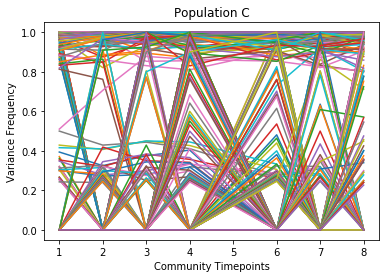

In [52]:
# 4. Check the dynamics of the Variance frequency in each population across timepoints
CMT_cols = ['CMT1 VQ', 'CMT2 VQ', 'CMT3 VQ','CMT4 VQ', 'CMT6 VQ', 'CMT7 VQ', 'CMT8 VQ']
time_points =  list(map(lambda x: int(x[3]), CMT_cols))
plot_variance_abundance_along_timepoints(vcfs_C_, time_points, CMT_cols, 'C')
vcfs_C_.head(5)

In [124]:
# 5. Find the variances of three categories in the indicated population 
cat1, cat2, cat3 = find_three_categories(vcfs_C_, CMT_cols, thresh = [0, 0.05, 0.8])
print(len(cat3))
cat2

51


,Name,Minimum,Maximum,Sequence,locus_tag,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ
117,ACGTAAC,6140578.0,6140584.0,GGCCCGA,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.243,0.240,0.00,0.258,0.0,0.246,0.0
125,TACTCG,6140589.0,6140594.0,GTGCTC,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.000,0.327,0.25,0.269,0.0,0.277,0.0
162,C,646916.0,646916.0,T,SCO0606,Substitution,"StF55.30, unknown, len: 324 aa. Contains possi...",0.000,0.000,0.00,1.000,0.0,1.000,1.0


In [ ]:
# 6. Though variance located in genes has a clear locus_tag, 
#    we have no idea which intergenetic regions the variances in these regions belong to.
#    We will first generate a complete genome_table for S.coelicolor where the "Minimum" and "Maximum", as well as
#    the correct locus_tag for all genes and intergenetic regions. 
#    We will then find the genes or intergenetic regions for all the variances of an indicated category. 

In [ ]:
# 6-1. Generate the genome_table_coelicolor

In [101]:
# Find all genes in S.coelicolor https://biocyc.org/group?id=:ALL-GENES&orgid=SCO
filepath = "G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\"
filename = "All_genes_of_S._coelicolor.txt"
all_genes = pd.read_table(filepath+filename)
all_genes.head(5)
# all_genes.where(all_genes['Left-End-Position'] > all_genes['Right-End-Position']).dropna()

,Gene Name,Accession-1,Left-End-Position,Right-End-Position,Product
0,SCP1.89C,NaN,87214,88383,SCP1.89C-MONOMER
1,SCO2671,NaN,2907738,2908151,SCO2671-MONOMER
2,SCO6250,NaN,6873167,6873760,SCO6250-MONOMER
3,SCO0787,NaN,833931,835199,SCO0787-MONOMER
4,SCO4108,NaN,4507333,4508376,SCO4108-MONOMER


In [102]:
# Remove the info of the plasmids (as M145 strain of our S.coelicolor is without any plasmid)
mask = all_genes.apply(lambda row: not row["Gene Name"].startswith("SCP"), axis = 1)
all_genes_ = all_genes.loc[mask]
all_genes_ = all_genes_.sort_values(by = ["Left-End-Position", "Right-End-Position"]).reset_index().drop(["index", "Accession-1"], axis = 1)
all_genes_.columns = ["Region Name", "Minimum", "Maximum", "Product"]
all_genes_.head(5)

,Region Name,Minimum,Maximum,Product
0,SCO0001,446,1123,SCO0001-MONOMER
1,SCO0002,1252,3813,SCO0002-MONOMER
2,SCO0003,3869,6220,SCO0003-MONOMER
3,SCO0004,6226,7173,SCO0004-MONOMER
4,SCO0005,7187,9307,SCO0005-MONOMER


In [103]:
# Find all intergenetic regions and label them in order
inter_left = (all_genes_["Maximum"].append(pd.Series([0])) + 1).sort_values().reset_index().drop("index", axis=1)
inter_right =(all_genes_["Minimum"].append(pd.Series([8667507])) - 1).sort_values().reset_index().drop("index", axis=1)
all_intergenes = pd.DataFrame()
names = pd.Series(map(lambda num:"Intergene"+str(num), range(1, len(inter_left)+1)))
all_intergenes["Region Name"] = names
all_intergenes["Minimum"] = inter_left[0]
all_intergenes["Maximum"] = inter_right[0]
all_intergenes["Product"] = "Intergenetic region" 
all_intergenes.head(5)

,Region Name,Minimum,Maximum,Product
0,Intergene1,1,445,Intergenetic region
1,Intergene2,1124,1251,Intergenetic region
2,Intergene3,3814,3868,Intergenetic region
3,Intergene4,6221,6225,Intergenetic region
4,Intergene5,7174,7186,Intergenetic region


In [104]:
# Concat the genes and intergenes together to make full table
genomic_table_coelicolor = pd.concat([all_genes_, all_intergenes], 
                                     axis = 0).sort_values(by = ["Minimum", "Maximum"]).reset_index().drop("index", axis = 1)
genomic_table_coelicolor.head(5)

,Region Name,Minimum,Maximum,Product
0,Intergene1,1,445,Intergenetic region
1,SCO0001,446,1123,SCO0001-MONOMER
2,Intergene2,1124,1251,Intergenetic region
3,SCO0002,1252,3813,SCO0002-MONOMER
4,Intergene3,3814,3868,Intergenetic region


In [125]:
# 6-2 Locate all SNPs of the indicated category to the full genomic table
snp2geno_cat2 = find_genetic_region_for_SNPs(genomic_table_coelicolor, cat2)
print(len(snp2geno_cat2))
snp2geno_cat2.head(5)

3


,Minimum,Maximum,Name,Region Name,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ,Sequence
0,6140578.0,6140584.0,ACGTAAC,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.243,0.240,0.00,0.258,0.0,0.246,0.0,GGCCCGA
1,6140589.0,6140594.0,TACTCG,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.000,0.327,0.25,0.269,0.0,0.277,0.0,GTGCTC
2,646916.0,646916.0,C,SCO0606,Substitution,"StF55.30, unknown, len: 324 aa. Contains possi...",0.000,0.000,0.00,1.000,0.0,1.000,1.0,T


In [126]:
# Find existance of each variance at each timepoint
temp = snp2geno_cat2[CMT_cols] > 0
temp.columns = CMT_cols
snp2geno_cat2_ = pd.concat([snp2geno_cat2, temp], axis = 1)
snp2geno_cat2_.head(5)

,Minimum,Maximum,Name,Region Name,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,...,CMT7 VQ,CMT8 VQ,Sequence,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ
0,6140578.0,6140584.0,ACGTAAC,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.243,0.240,0.00,0.258,...,0.246,0.0,GGCCCGA,True,True,False,True,False,True,False
1,6140589.0,6140594.0,TACTCG,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.000,0.327,0.25,0.269,...,0.277,0.0,GTGCTC,False,True,True,True,False,True,False
2,646916.0,646916.0,C,SCO0606,Substitution,"StF55.30, unknown, len: 324 aa. Contains possi...",0.000,0.000,0.00,1.000,...,1.000,1.0,T,False,False,False,True,False,True,True


In [131]:
# 6-3 Compare the mutations from evolved community to the mutant populations streaked from T6-A population
# load table of variance of mutant populations
file = 'G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\Comunity mutants\\table_fixed_variance_mutants.csv'
mutant_table = pd.read_csv(file)
mutant_table = mutant_table.drop(['Unnamed: 0'], axis = 1)



boo1 = mutant_table['Name'].isin(snp2geno_cat2_['Name'])+0
boo2 = mutant_table['Minimum'].isin(snp2geno_cat2_['Minimum'])+0
boo3 = mutant_table['Maximum'].isin(snp2geno_cat2_['Maximum'])+0
msk = boo1 + boo2 + boo3 == 3

mutant_table.loc[msk]

,locus_tag,Name,Minimum,Maximum,R1,R2,R3,R4,R5,RH1,...,RH5,W1,W2,W3,W4,W5,WS1,WS2,WT,WT VQ


In [107]:
# 6-4 Group these variances by "Region Name" and calulate the average abundance and the times of the variances at each "Region"
# group_cat3 = snp2geno_cat3_.groupby(by = "Region Name").agg({"CMT1 VQ": ["mean", "std"],"CMT2 VQ": ["mean", "std"], 
#                                                              "CMT3 VQ": ["mean", "std"], "CMT4 VQ": ["mean", "std"],
#                                                              "CMT6 VQ": ["mean", "std"], "CMT7 VQ": ["mean", "std"],
#                                                              "CMT8 VQ": ["mean", "std"], "CMT1": "sum", "CMT2": "sum", 
#                                                              "CMT3": "sum", "CMT4": "sum", "CMT6": "sum", "CMT7": "sum", "CMT8": "sum"}).fillna(0)

# or just calulate how many variances occur in each region

group_cat3_ = snp2geno_cat3_.groupby(by = "Region Name").agg("sum").drop(["Minimum", "Maximum"], axis = 1)
print(len(group_cat3_))
group_cat3_.head(5)

19


,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ
Region Name,,,,,,,,,,,,,,
Intergene2811,0.000,0.000,0.0,0.0,2.441,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
Intergene3894,1.000,0.000,0.0,0.0,1.886,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
Intergene4489,2.537,1.714,0.0,0.0,3.666,0.0,0.0,3.0,2.0,0.0,0.0,9.0,0.0,0.0
Intergene6457,0.000,0.000,0.0,0.0,1.055,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
Intergene6747,0.000,0.000,0.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [108]:
# Reorder the "Region name" in the grouped df according to their positions in the genomic_table_coelicolor
full_pos = genomic_table_coelicolor["Region Name"]
group_pos = group_cat3_.reset_index()["Region Name"]
pos_mask = full_pos.isin(group_pos)
group_pos_ord = full_pos.loc[pos_mask]
group_cat3_ord = group_cat3_.loc[group_pos_ord, CMT_cols]
group_cat3_ord

,CMT1 VQ,CMT1 VQ,CMT2 VQ,CMT2 VQ,CMT3 VQ,CMT3 VQ,CMT4 VQ,CMT4 VQ,CMT6 VQ,CMT6 VQ,CMT7 VQ,CMT7 VQ,CMT8 VQ,CMT8 VQ
Region Name,,,,,,,,,,,,,,
SCO0299,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.068,4.0,0.0,0.0,0.0,0.0
SCO0300,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.328,5.0,0.0,0.0,0.0,0.0
SCO1903,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.760,1.0,0.0,0.0,0.0,0.0
SCO2097,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.675,1.0,0.0,0.0,0.0,0.0
SCO2191,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.702,1.0,0.0,0.0,0.0,0.0
SCO2441,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.762,1.0,0.0,0.0,0.0,0.0
SCO2574,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.615,1.0,0.0,0.0,0.0,0.0
SCO2792,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.686,1.0,0.0,0.0,0.0,0.0
Intergene2811,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,2.441,3.0,0.0,0.0,0.0,0.0


Text(0.5,0,'Generations')

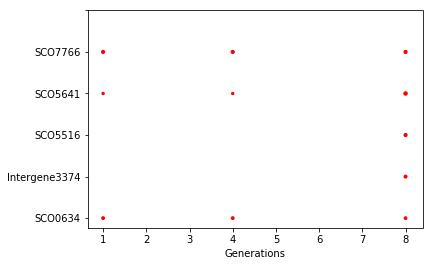

In [41]:
timepoints = {0:1, 1:4, 2:8}
x = range(3)
y = range(len(group_cat3_ord))
colnames = group_cat3_ord.columns
fig = plt.figure()
ax = fig.add_subplot(111)
for ii in x:
    for jj in y:
        ax.scatter(timepoints[ii], jj, c = 'r', s = 10 * group_cat3_ord.iloc[jj][colnames[ii]])
        #print(ii,jj, group_cat3_ord.iloc[jj][colnames[ii]])
        
ax.set_yticks(np.arange(0,6,1))
ax.set_yticklabels(group_cat3_ord.index)
ax.set_xlabel("Generations")

,Name,Minimum,Maximum,Sequence,locus_tag,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ
14,G,8595557.0,8595557.0,C,SCO7766,None,"SC5E9.14, conserved hypothetical protein, len:...",1.000,1.000,0.00,1.000,1.000,1.000,1.0
107,T,6140596.0,6140596.0,C,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.313,0.327,0.00,0.320,0.274,0.310,0.0
117,ACGTAAC,6140578.0,6140584.0,GGCCCGA,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.243,0.240,0.00,0.258,0.000,0.246,0.0
119,G,6008595.0,6008595.0,T,SCO5516,Substitution,"SC8D9.28c, probable integral membrane efflux p...",0.000,1.000,0.00,0.986,0.909,1.000,1.0
125,TACTCG,6140589.0,6140594.0,GTGCTC,SCO5641,Substitution,"SC6A9.26, probable transposase for IS1649, len...",0.000,0.327,0.25,0.269,0.000,0.277,0.0


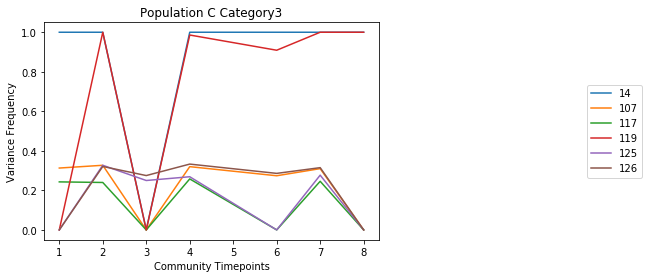

In [42]:
# 7. Find the genes that contribute to the indicated category in the indicated population
genes = find_contributed_gene_in_cat(cat3, time_points, CMT_cols, 'C', 'Category3')
genes.head(5)

In [43]:
# 8. Import the cluster information from antiSMASH database

filepath = 'G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\Coomunity mutants\\antiSMASH_Streptomyces_coelicolor\\'
filename = 'index.html'
cluster_info = pd.read_html(filepath+filename)[0].drop(0) #Read the cluster info from the html file and remove the first row

cluster_info.head(5)

,Cluster,Type,From,To,Most similar known cluster,MIBiG BGC-ID
1,Cluster 1,Cf_putative,26527.0,46201.0,-,-
2,Cluster 2,T1pks-Otherks,86637.0,139654.0,Leinamycin_biosynthetic_gene_cluster (2% of ge...,BGC0001101_c1
3,Cluster 3,Terpene,166501.0,192038.0,Isorenieratene_biosynthetic_gene_cluster (100%...,BGC0000664_c1
4,Cluster 4,Cf_putative,212551.0,231465.0,-,-
5,Cluster 5,Lantipeptide,235986.0,271084.0,Sanglifehrin_A_biosynthetic_gene_cluster (4% o...,BGC0001042_c1


In [44]:
# 9. Find the biosynthetic cluster where the gene of the variance belongs to
g2c = find_cluster_for_SNPs(cluster_info, genes)
g2c

,Name,Minimum,Maximum,Sequence,locus_tag,Protein Effect,note,CMT1 VQ,CMT2 VQ,CMT3 VQ,CMT4 VQ,CMT6 VQ,CMT7 VQ,CMT8 VQ,Cluster,Type
0,G,8595557.0,8595557.0,C,SCO7766,None,"SC5E9.14, conserved hypothetical protein, len:...",1.0,1.0,0.0,1.0,1.0,1.0,1.0,Cluster 89,Cf_putative


In [ ]:
def generate_data_for_PCA(vct_cmt):
    '''
    Input:
    vcf_cmt =  the merged dataframe of vcf of all repeats of one time point from function merge_repeates
    
    Output:
    data = data frame for PCA
    '''
    cols = vcf_cmt.columns.values[4:]
    data = vcf_cmt[cols]
    return data

In [ ]:
def Principle_Analysis_across_populations(data):
    '''
    Input:
    data = selected data for PCA    
    Output:
    pca = the PCA object that fit into data
    pca_data = the transformed data (principle components) in the principle space 
    '''
    #Center and preprocessing the data
    scaled_data = preprocessing.scale(data.T)
    # Create PCA obj, Check the cookbook if need any other parameter settings
    pca = PCA()
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    return pca, pca_data

In [ ]:
def Scree_plot(pca, savepath):
    '''
    Input:
    pca = fitted pca from Principle_Analysis_across_populations(vcf_cmt, cols)
    savepath
    Output:
    Screeplot
    '''
    per = np.round(pca.explained_variance_ratio_*100, decimals = 1)
    labels = ['PC' + str(x) for x in range(1, len(per)+1)]
    plt.bar(x = range(1,len(per)+1), height = per, tick_label = labels)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot')
    #plt.savefig(save_path) 
    plt.show()
    
    

In [ ]:
def PCA_Scatter_plot(pca, data, pca_data, title, save_path) :
    '''
    Input:
    pca = fitted PCA obj
    data = The original data before PCA
    pca_data = the transformed data after PCA
    title
    save_path
    
    Output:
    PCA scatter plot with annotations
    '''
    per = np.round(pca.explained_variance_ratio_*100, decimals = 1)
    indice = data.columns.values
    labels = ['PC' + str(x) for x in range(1, len(per)+1)]
    pca_df = pd.DataFrame(pca_data, index=indice, columns=labels)
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c = 'b')
    plt.xlabel('PC1 ({0}%)'.format(per[0]))
    plt.ylabel('PC2 ({0}%)'.format(per[1]))
    plt.title(title)
    #Add annotation to each plotted sample
    for sample in pca_df.index:
        plt.annotate(sample, (pca_df.loc[sample, 'PC1'], pca_df.loc[sample, 'PC2']),(pca_df.loc[sample, 'PC1']+0.5, pca_df.loc[sample, 'PC2']+0.5) )
    #plt.savefig(save_path)    
    plt.show() 

In [ ]:
def find_key_variance_locus(pca, vcf_cmt, data, num_key):
    # Determine which variance position contribute the most to the variability of the community popuplations
    '''
    Input:
    pca = fitted PCA obj
    data = The original data before PCA
    num_key = Number of the top contributed locus
    vcf 
    Output:
    df of key loci that contribute most to each princible component (PC1, PC2)
    '''
    loading_scores_PC1 = pd.Series(pca.components_[0,:], index = data.index).abs().sort_values(ascending = False)
    loading_scores_PC2 = pd.Series(pca.components_[1,:], index = data.index).abs().sort_values(ascending = False)

    # Find the locus tag of these variance 
    inds1 = loading_scores_PC1.iloc[0:10].index
    inds2 = loading_scores_PC2.iloc[0:10].index
    key_loci_PC1 = vcf_cmt.loc[inds1, ['locus_tag', 'Protein Effect']]
    key_loci_PC2 = vcf_cmt.loc[inds2, ['locus_tag', 'Protein Effect']]
    return key_loci_PC1, key_loci_PC2

In [ ]:
## Select part of vcf_cmt for PCA
data = generate_data_for_PCA(vcfs_A)
data.head(3)


In [ ]:
## Perform PCA on data
pca, pca_data = Principle_Analysis_across_populations(data)

In [ ]:
## Plot Scree plot to see the representative percentage of variebility of each PC
save_path = "G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\Coomunity mutants\\CMT4\\Scree_plot_CMT4.png"
Scree_plot(pca, save_path)

In [ ]:
## Plot data in PC space
save_path = "G:\\Dropbox (Vetsigian lab)\\Vetsigian lab Team Folder\\Ye\\Genomics\\Coomunity mutants\\CMT4\\PCA_for_Variance_Freq_of_CMT8.png"
title = 'PCA for CMT8'
PCA_Scatter_plot(pca, data, pca_data, title, save_path)

In [ ]:
## Find which locus play the key roles in each PC
num_key = 10 #Find top 10 key locus
key_loci_PC1, key_loci_PC2 = find_key_variance_locus(pca, vcf_cmt, data, num_key)
print(key_loci_PC1)
print('---------------------------------------------------------------')
print(key_loci_PC2)